The provided script is designed for the analysis of collective behavior in nematodes. 

Here we conduct the analysis comparing all the strains belonging to the divergent data set. 

# Load Packages #

In [1]:
from PIL import Image
from math import sqrt
from matplotlib import rcParams
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_normal
from scipy.stats import zscore
from skimage import color
from skimage import draw, measure
from skimage.draw import circle_perimeter
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.measure import label, regionprops
from skimage.transform import resize
from sklearn.cluster import KMeans
from tabulate import tabulate
import cv2     # for image conversion
import glob
import h5py    # for reading HDF5 files 
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pywt
import re    # use it to sort but not sure what it is!
import seaborn as sns
import matplotlib.patches as patches

# Data extraction #

### Data set infromation overview: ###

1. Divergent Sets:

    Consists of 12 genotypically distinct strains. These are strains that are further apart on the phenotypic tree. 
    Ideal for determining broad-sense heritability with repeated measurements of specific phenotypes.
    This allows us to look into the relationship between the behavior and the genetic makeup. 

2. Mapping Sets:

    Comprises 48 strains suitable for collecting phenotype data for broad diversity or genome-wide association studies.
    Using multiple strain sets can enhance the statistical strength in genome-wide association studies.

### Workflow: Handling and processing image data stored in HDF5 files ###

General steps: 
1. Frame extraction from hdf5 files and saving 

2. Feature extraction from each frame 

3. Analysis of features 

More in detail: 

In hdf5_frames_extractor: 

1. The script sets the paths to your HDF5 files and the directory for extracted frames.

2. It ensures the output directory exists for each strain and each experiment.

3. It retrieves the paths of HDF5 files for each strain and creates corresponding output directories.

4. It extracts frames from HDF5 files and saves them in the respective experiment subfolders.

Strain_comparison_study: 

5. Load Images: Use the load_images_from_folder function to load frames from each experiment.

6. It creates a dictionary labels_strain_list mapping experiment labels to the loaded images.

7. Feature Extraction: Write functions to extract the necessary features from each frame.

8. Aggregate and Analyze: Aggregate the features per experiment, and then perform statistical analyses and visualizations.

9. Comparison: Compare these features across different strains.

### Functions: ###

In [2]:
# Loading and selecting frames 
def select_frames(folder, num_frames):
    """
    Select a specified number of frames from a folder.
    """
    image_files = sorted(glob.glob(os.path.join(folder, '*.jpg')))
    total_frames = len(image_files)

    if total_frames <= num_frames:
        return image_files

    indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
    return [image_files[i] for i in indices]

def extract_experiment_name(file_path):
    """
    Extract the experiment name from the file path.
    """
    base_name = os.path.basename(file_path)
    name_parts = base_name.split('_')
    return '_'.join(name_parts[:-1])  # Exclude the extension

def read_image(image_path, color_mode=cv2.IMREAD_GRAYSCALE):
    """
    Reads an image from the given path in the specified color mode.
    """
    image = cv2.imread(image_path, color_mode)
    if image is None:
        raise ValueError(f"Could not read the image file {image_path}")
    return image

# Normalizing images 
# def equalize_histogram(image):
    if len(image.shape) == 3:  # Check if the image is colored (3 channels)
        # Convert to YUV color space
        yuv_img = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        
        # Equalize the histogram of the Y (luminance) channel
        yuv_img[:, :, 0] = cv2.equalizeHist(yuv_img[:, :, 0])
        
        # Convert back to BGR color space
        equalized_img = cv2.cvtColor(yuv_img, cv2.COLOR_YUV2BGR)
    else:
        # For grayscale images
        equalized_img = cv2.equalizeHist(image)

    return equalized_img


# Noise filteirng and cleaning 
def segment_and_close_areas(image, threshold_value, closing_kernel_size=(15, 15)):
    """
    Segment lighter areas in the image based on a threshold and close holes in white areas.
    
    Parameters:
    - image: The input image to segment.
    - threshold_value: The threshold value for segmentation.
    - closing_kernel_size: The size of the kernel used for morphological closing.
    """
    # Apply threshold to segment the image
    _, thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Define the closing kernel
    closing_kernel = np.ones(closing_kernel_size, np.uint8)
    
    # Apply morphological closing
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, closing_kernel)
    
    # Further clean up using opening, if necessary
    opening_kernel = np.ones((3, 3), np.uint8)
    cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, opening_kernel)
    
    return cleaned

def subtract_background(frame_path, num_background_frames=50):
    """
    Subtracts the background from a frame by averaging a randomly selected number
    of frames from the same folder and subtracting it from the frame.
    """
    folder = os.path.dirname(frame_path)
    frame_files = sorted(glob.glob(os.path.join(folder, '*.jpg')))

    # Randomly select frames for background calculation
    if len(frame_files) > num_background_frames:
        selected_frames = random.sample(frame_files, num_background_frames)
    else:
        selected_frames = frame_files

    # Ensure the selected frame is included in the background calculation
    if frame_path not in selected_frames:
        selected_frames.append(frame_path)

    background = np.mean([read_image(f) for f in selected_frames], axis=0)

    frame = read_image(frame_path)
    subtracted = cv2.absdiff(frame.astype(np.uint8), background.astype(np.uint8))

    return subtracted

def apply_threshold(image, threshold_value):
    """
    Applies thresholding to an image.
    """
    _, thresh = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresh


def calculate_features(image, frame_number, threshold_value=30):
    """
    Calculate features for a given image and frame number after thresholding
    and closing, ensuring correct handling of center of mass positions without
    applying any unnecessary adjustments.
    """
    # Apply thresholding and closing to segment the image
    segmented = segment_and_close_areas(image, threshold_value)
    
    labeled_areas = label(segmented)
    properties = regionprops(labeled_areas)

    image_center = np.array([image.shape[1] / 2, image.shape[0] / 2])

    features = []
    for prop in properties:
        center_of_mass = prop.centroid
        distance_from_center = np.linalg.norm(np.array([center_of_mass[1], center_of_mass[0]]) - image_center) # this is modified in order to fit coordinates of images 
        features.append({
            'frame': frame_number,
            'center_of_mass': center_of_mass,
            'distance_from_center': distance_from_center,
            'area': prop.area
        })
    return features

### Image Loading ###

1. Iterates over each strain folder.

2. For each experiment within a strain, it selects a specified number of frames.

3. Prints the selected frames for diagnostics.

4. Extracts features from the selected frames.

5. Loads the selected images and stores them in labels_strain_list.

6. Prints the number of images loaded for each experiment.

In [15]:
# Main analysis loop
root_path = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames'
experiment_features = {}

for strain_folder in os.listdir(root_path):
    strain_path = os.path.join(root_path, strain_folder)
    if os.path.isdir(strain_path):
        experiment_features[strain_folder] = {}
        for experiment_folder in os.listdir(strain_path):
            experiment_path = os.path.join(strain_path, experiment_folder)
            if os.path.isdir(experiment_path):
                selected_frame_paths = select_frames(experiment_path, 3)
                experiment_label = extract_experiment_name(experiment_path)
                experiment_features[strain_folder][experiment_label] = []
                for frame_number, frame_path in enumerate(selected_frame_paths):
                    frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

                    # Apply histogram equalization
                    # equalized_frame = equalize_histogram(frame)

                    # Process the equalized frame
                    frame_features = calculate_features(frame, frame_number)
                    experiment_features[strain_folder][experiment_label].append(frame_features)

# Example usage of the structured data
# print_structure(experiment_features) # Uncomment to print the structure
selected_frame_paths

['/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/LKC34/3.4_4_lkc34_ae_Set0_Pos0_Ch3_23012018_122849/000000.jpg',
 '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/LKC34/3.4_4_lkc34_ae_Set0_Pos0_Ch3_23012018_122849/033500.jpg',
 '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/LKC34/3.4_4_lkc34_ae_Set0_Pos0_Ch3_23012018_122849/067500.jpg']

### Check structure ###

In [4]:
def print_structure(data_dict):
    if not isinstance(data_dict, dict):
        print("The data is not a dictionary.")
        return

    for key, value in data_dict.items():
        print(f"Key: {key}")
        if isinstance(value, dict):
            for subkey, subvalue in value.items():
                print(f"  Subkey: {subkey}")
                if isinstance(subvalue, dict):
                    for subsubkey, subsubvalue in subvalue.items():
                        print(f"    Subsubkey: {subsubkey}, Value: {subsubvalue}")
                else:
                    print(f"  Value: {subvalue}")
        else:
            print(f"Value: {value}")
        print("-------")  # Just to separate between entries for readability

# Example usage
print_structure(experiment_features)

Key: N2
  Subkey: 1.1_4_n2_6b_Set0_Pos0_Ch3_14012018
  Value: [[{'frame': 0, 'center_of_mass': (7.5, 239.5), 'distance_from_center': 1284.0220013691355, 'area': 7680.0}, {'frame': 0, 'center_of_mass': (292.99433395004627, 1014.9017113783534), 'distance_from_center': 731.0622837029547, 'area': 8648.0}, {'frame': 0, 'center_of_mass': (528.356103286385, 1405.8483568075117), 'distance_from_center': 625.6764658719819, 'area': 4260.0}, {'frame': 0, 'center_of_mass': (615.470066518847, 1502.5086474501109), 'distance_from_center': 629.1798091441347, 'area': 4510.0}, {'frame': 0, 'center_of_mass': (681.496005723143, 1114.0213425539525), 'distance_from_center': 354.13673660158076, 'area': 8387.0}, {'frame': 0, 'center_of_mass': (768.1766792285524, 1557.410995344713), 'distance_from_center': 591.5850415664415, 'area': 4511.0}, {'frame': 0, 'center_of_mass': (782.7239900699616, 507.5797788309637), 'distance_from_center': 570.003471743845, 'area': 4431.0}, {'frame': 0, 'center_of_mass': (811.094794

# Visualization #

### To visualize one frame detected blobs ###
I ahve added a close_area function that closes up the white areas but I am not sure if I need it.

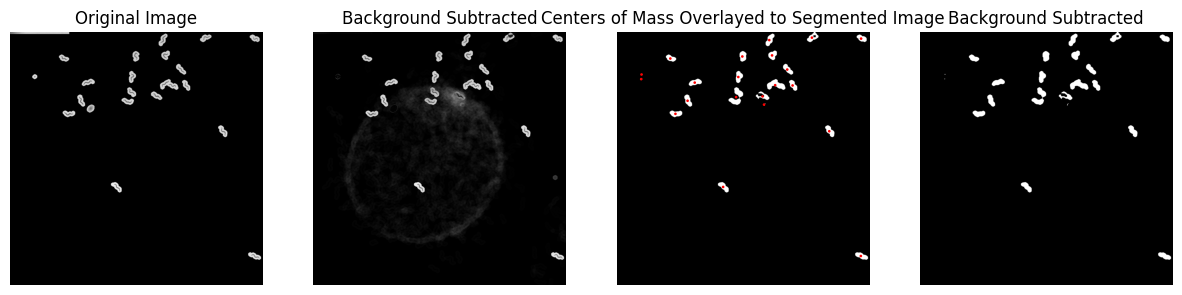

In [24]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.measure import label, regionprops
import cv2
import numpy as np
import glob
import os
import random

# Assuming all the other functions (read_image, subtract_background, etc.) are defined as provided

def visualize_processing_and_results(frame_path, threshold_value=50):
    """
    Visualizes the original frame, the frame after background subtraction and thresholding,
    and the frame with the detected centers of mass overlayed, ensuring vertical positions are handled properly.
    """
    original_image = read_image(frame_path, cv2.IMREAD_GRAYSCALE)
    subtracted = subtract_background(frame_path)
    segmented = segment_and_close_areas(subtracted, threshold_value)
    labeled_areas = label(segmented)
    properties = regionprops(labeled_areas)

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))

    # Original Image
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Image after Background Subtraction and Histogram Equalization
    ax[1].imshow(subtracted, cmap='gray')
    ax[1].set_title('Background Subtracted')
    ax[1].axis('off')

    # Image with Centers of Mass
    ax[2].imshow(segmented, cmap='gray')
    for prop in properties:
        # Use the original centroid coordinates directly for plotting
        # This assumes y-coordinate adjustments were not necessary as they are already correct
        center_of_mass = prop.centroid
        circ = patches.Circle((center_of_mass[1], center_of_mass[0]), radius=5, edgecolor='red', facecolor='none')
        ax[2].add_patch(circ)

    ax[2].set_title('Centers of Mass Overlayed to Segmented Image')
    ax[2].axis('off')

    ax[3].imshow(segmented, cmap='gray')
    ax[3].set_title('Background Subtracted')
    ax[3].axis('off')

    plt.show()


# Example usage
frame_path = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/MY23/1.2_7_nic252_e2_my23_6c_Set0_Pos0_Ch6_15012018_165449/000000.jpg'  
visualize_processing_and_results(frame_path)

### Time Series for Each Strain (All Experiments) ###

Here we selct one strain and one feature and compute the time series for all videos belonging to that strain. Each point in the time series is the average of the feature for a specific frame. 

In [21]:
import plotly.graph_objects as go

def process_videos_in_strain(strain_folder, feature_name):
    """
    Process all videos in a strain folder and extract time series of a specific feature.
    """
    video_feature_averages = []  # List to hold the average feature values for each video

    for video_folder in sorted(glob.glob(os.path.join(strain_folder, '*/'))):
        frame_features = []

        for frame_path in sorted(glob.glob(os.path.join(video_folder, '*.jpg'))):
            frame = read_image(frame_path, cv2.IMREAD_GRAYSCALE)
            frame_feature_data = calculate_features(frame, frame_number=0)

            # Extract and store the specific feature for each frame
            feature_values = [prop[feature_name] for prop in frame_feature_data]
            frame_features.append(np.mean(feature_values))  # Average feature for the frame

        # Average feature across all frames in the video
        video_feature_averages.append(frame_features)

    return video_feature_averages

def plot_feature_time_series_plotly(strain_folder, feature_name='area'):
    """
    Plot the time series of a specific feature for each video in the strain folder using plotly for interactivity.
    """
    time_series_data = process_videos_in_strain(strain_folder, feature_name)
    
    fig = go.Figure()
    
    for i, video_data in enumerate(time_series_data):
        fig.add_trace(go.Scatter(x=list(range(len(video_data))), y=video_data,
                                 mode='lines+markers',
                                 name=f'Video {i+1}',
                                 text=[f'Frame {j}' for j in range(len(video_data))]))

    fig.update_layout(title=f'Time Series of {feature_name} for Strain in {strain_folder}',
                      xaxis_title='Frame Number',
                      yaxis_title=f'Average {feature_name} per Frame',
                      hovermode='closest')
    
    fig.show()

strain_folder = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/MY23'
plot_feature_time_series_plotly(strain_folder, feature_name='distance_from_center')

### Violin Plots for Each Strain (Separate Experiments) ###

In [29]:
from skimage.measure import label, regionprops  # Ensure these are defined or imported correctly

import plotly.graph_objects as go

def plot_feature_violin_plotly(strain_folder, feature_name='area'):
    """
    Plot a series of violin plots with individual points for the distribution of average feature values per frame
    for each video in the strain folder using plotly for interactivity.
    """
    time_series_data = process_videos_in_strain(strain_folder, feature_name)
    
    fig = go.Figure()
    
    # Add a violin plot for each video, with individual points shown
    for i, video_data in enumerate(time_series_data):
        fig.add_trace(go.Violin(y=video_data,
                                name=f'Video {i+1}',
                                box_visible=True,
                                meanline_visible=True,
                                points='all',  # Show all individual points
                                jitter=0.05,  # Add a slight jitter to the points to reduce overlap
                                pointpos=0))  # Position the points on the violin plot
    
    fig.update_layout(title=f'Distribution of {feature_name} for Strain in {strain_folder}',
                      yaxis_title=f'Average {feature_name} per Frame',
                      xaxis_title='Video Number',
                      hovermode='closest')
    
    fig.show()

strain_folder = '/Volumes/TOSHIBA_EXT/Phenotype_features_collective/Data/ExtractedFrames/MY23'
plot_feature_violin_plotly(strain_folder, feature_name='distance_from_center')

### Average Time Series for All Strains ###

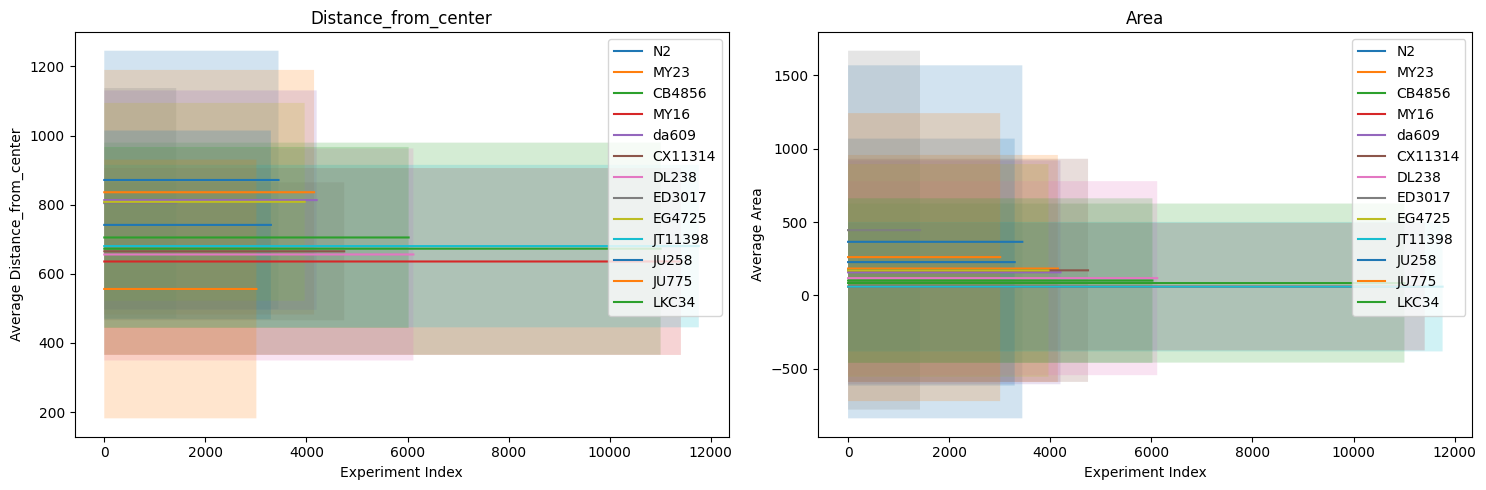

In [10]:
def plot_average_time_series(experiment_features):
    # Determine the number of unique features (excluding 'center_of_mass')
    sample_experiment = next(iter(next(iter(experiment_features.values())).values()))
    feature_keys = [key for key in sample_experiment[0].keys() if key != 'center_of_mass']

    num_features = len(feature_keys)
    fig, axs = plt.subplots(1, num_features, figsize=(15, 5), squeeze=False)
    axs = axs.flatten()

    for j, feature_key in enumerate(feature_keys):
        for strain, experiments in experiment_features.items():
            all_feature_values = []
            for exp_label, features in experiments.items():
                feature_values = [feature[feature_key] for feature in features]
                all_feature_values.extend(feature_values)

            avg_feature = np.mean(all_feature_values)
            std_feature = np.std(all_feature_values)
            x = range(len(all_feature_values))

            axs[j].plot(x, [avg_feature] * len(x), label=strain)  # Constant line for average
            axs[j].fill_between(x, [avg_feature - std_feature] * len(x), [avg_feature + std_feature] * len(x), alpha=0.2)

        axs[j].set_title(feature_key.capitalize())
        axs[j].set_xlabel('Experiment Index')
        axs[j].set_ylabel(f'Average {feature_key.capitalize()}')
        axs[j].legend()

    plt.tight_layout()
    plt.show()

plot_average_time_series(experiment_features)


### Violin Plots Averaging Over All Experiments for All Strains ###

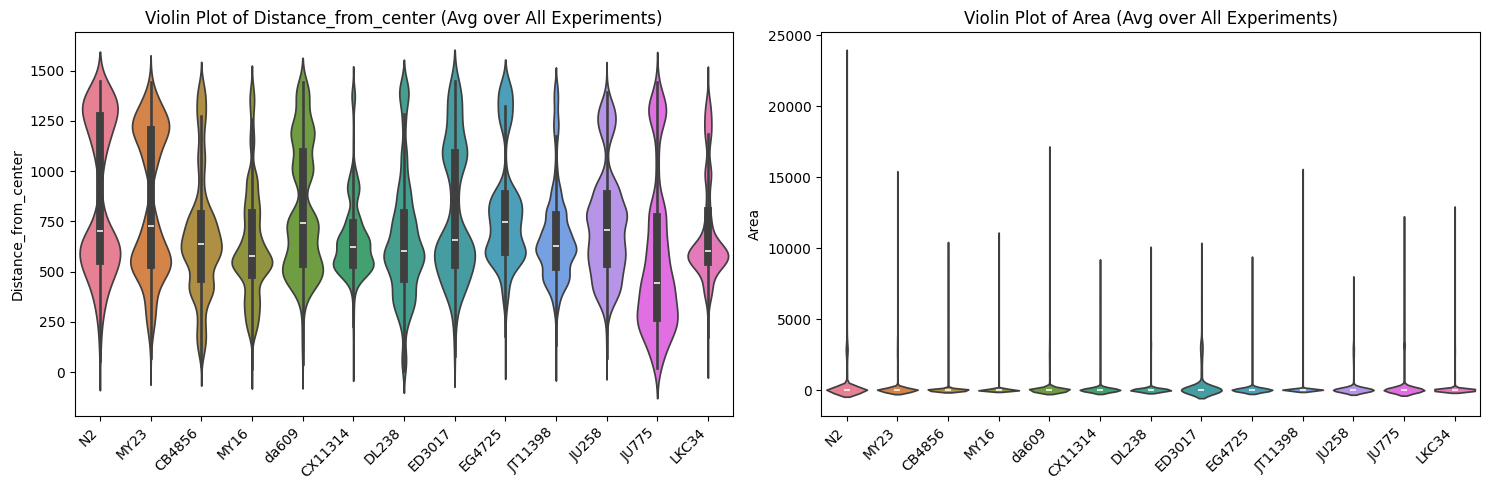

In [12]:
def plot_violin_plots_avg_all_experiments(experiment_features):
    # Determine the number of unique features (excluding 'center_of_mass')
    sample_experiment = next(iter(next(iter(experiment_features.values())).values()))
    feature_keys = [key for key in sample_experiment[0].keys() if key != 'center_of_mass']

    num_features = len(feature_keys)
    fig, axs = plt.subplots(1, num_features, figsize=(15, 5), squeeze=False)
    axs = axs.flatten()

    for j, feature_key in enumerate(feature_keys):
        feature_data = []

        for strain, experiments in experiment_features.items():
            all_feature_values = []
            for exp_label, features in experiments.items():
                feature_values = [feature[feature_key] for feature in features]
                all_feature_values.extend(feature_values)
            feature_data.append(all_feature_values)

        sns.violinplot(data=feature_data, ax=axs[j])
        axs[j].set_xticks(range(len(experiment_features)))
        axs[j].set_xticklabels(experiment_features.keys(), rotation=45, ha='right')  # Rotate labels for better readability
        axs[j].set_title(f"Violin Plot of {feature_key.capitalize()} (Avg over All Experiments)")
        axs[j].set_ylabel(feature_key.capitalize())

    plt.tight_layout()
    plt.show()

plot_violin_plots_avg_all_experiments(experiment_features)
